In [2]:
from pathlib import Path
import warnings

import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import numpy as np

sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi=120, facecolor="white")

warnings.filterwarnings("ignore", category=FutureWarning, module="anndata.utils")



In [7]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="Variable names are not unique",
    category=UserWarning,
    module="anndata"
)


VISIUM_OUTS = Path("../data/visium_breast_cancer_blockA_section1/outs").resolve()

adata = sq.read.visium(
    path=VISIUM_OUTS,
    counts_file="filtered_feature_bc_matrix.h5",
    load_images=True,
)


print(adata)
print(list(adata.uns["spatial"].keys()))

adata.var_names_make_unique()
adata.obs_names_make_unique()



assert "spatial" in adata.obsm
assert "spatial" in adata.uns
print("spatial coords + metadata present")







reading C:\Bioinfo Projects\spatial-visium-transcriptomics\data\visium_breast_cancer_blockA_section1\outs\filtered_feature_bc_matrix.h5
 (0:00:02)
AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
['V1_Breast_Cancer_Block_A_Section_1']
spatial coords + metadata present


In [8]:
#QC gene sets and metrics

adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")

sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt"],
    percent_top=None,
    log1p=False,
    inplace=True,
)

adata.obs[["total_counts", "n_genes_by_counts", "pct_counts_mt"]].describe()


,total_counts,n_genes_by_counts,pct_counts_mt
count,3798.000000,3798.000000,3798.000000
mean,21814.714844,5621.992891,4.008864
std,13822.857422,2085.858613,1.830299
min,578.000000,430.000000,1.117827
25%,10201.750000,4053.000000,2.761408
50%,20761.500000,6026.500000,3.503653
75%,30463.250000,7276.000000,4.678455
max,81624.000000,10153.000000,14.415201


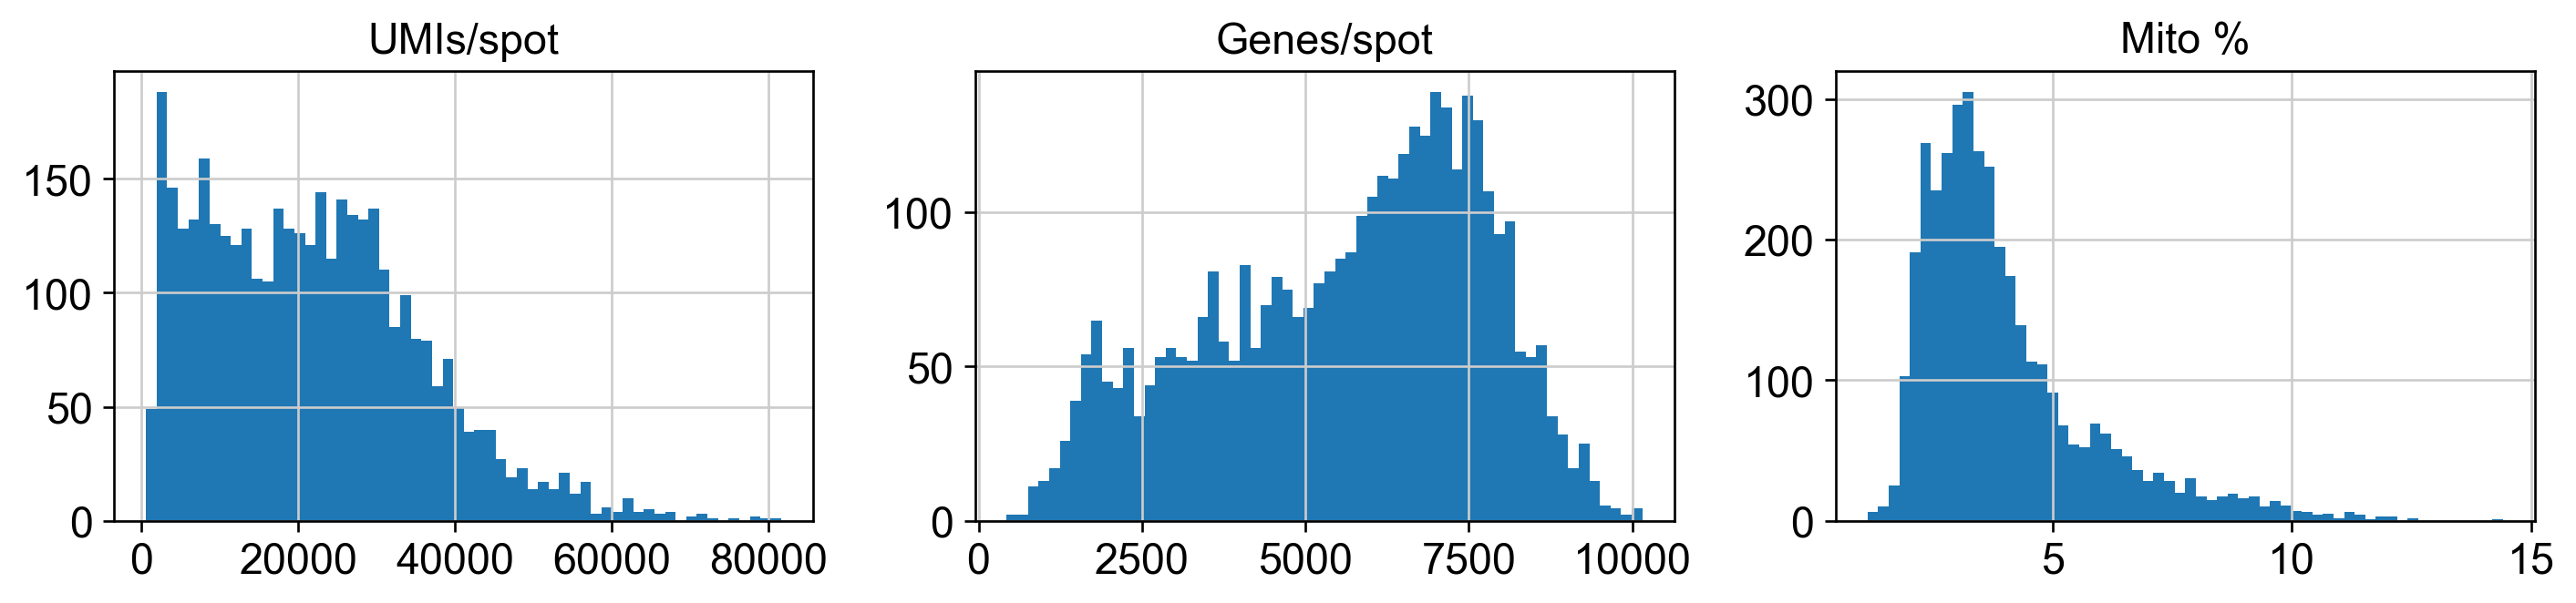

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].hist(adata.obs["total_counts"], bins=60); ax[0].set_title("UMIs/spot")
ax[1].hist(adata.obs["n_genes_by_counts"], bins=60); ax[1].set_title("Genes/spot")
ax[2].hist(adata.obs["pct_counts_mt"], bins=60); ax[2].set_title("Mito %")
plt.tight_layout()


In [11]:
#Check

lib_id = list(adata.uns["spatial"].keys())[0]
print("library_id:", lib_id)
print("available images:", list(adata.uns["spatial"][lib_id]["images"].keys()))
print("scalefactors keys:", adata.uns["spatial"][lib_id]["scalefactors"].keys())


library_id: V1_Breast_Cancer_Block_A_Section_1
available images: ['hires', 'lowres']
scalefactors keys: dict_keys(['spot_diameter_fullres', 'tissue_hires_scalef', 'fiducial_diameter_fullres', 'tissue_lowres_scalef'])


In [ ]:
import scanpy as sc

sc.pl.spatial(
    adata,
    color=["total_counts", "n_genes_by_counts", "pct_counts_mt"],
    img_key="hires",
    size=1.2,
    cmap="viridis",
    wspace=0.4,
)


In [19]:
qc_mask = (
    (adata.obs["total_counts"] >= 1000) &
    (adata.obs["n_genes_by_counts"] >= 800) &
    (adata.obs["pct_counts_mt"] <= 20)
)

adata.obs["pass_qc"] = qc_mask
adata.obs["pass_qc"].value_counts()


pass_qc
True     3793
False       5
Name: count, dtype: int64

In [ ]:
#Visualizing the removed spots

sc.pl.spatial(
    adata,
    color="pass_qc",
    img_key="hires",
    size=1.2,
)


In [23]:
adata_qc = adata[adata.obs["pass_qc"]].copy()
print(adata_qc)

from pathlib import Path
OUT = Path("../data/processed")
OUT.mkdir(exist_ok=True)

adata_qc.write_h5ad(OUT / "visium_breast_cancer_blockA_section1_qc.h5ad")


AnnData object with n_obs × n_vars = 3793 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'pass_qc'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'spatial', 'pass_qc_colors'
    obsm: 'spatial'


In [ ]:
#QC Summary

Visium breast cancer section shows coherent spatial variation in sequencing depth and gene complexity. 
Conservative filtering removed only a small number of low-quality edge spots while preserving interior tissue structure, ensuring validity for downstream spatial neighborhood and graph-based analyses.